# Check for contact between bricks
MP, 2022-10, develop for the FEM model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

TOL = 1e-4

In [59]:
setup_wall = {'name': 'wall1x2-down-dev',
         'bricks': {1: {'type': 'regular', 'nx': 2, 'nz': 1},
                    2: {'type': 'regular', 'nx': 4, 'nz': 1}},
         'parts': {1: {'brick_id': 1, 'loc': (0, 0, 0)},
                       2: {'brick_id': 2, 'loc': (16, 0, 0)},
                       #3: {'brick_id': 1, 'loc': (32, 0, 0)},
                       4: {'brick_id': 1, 'loc': (48, 0, 0)},
                       5: {'brick_id': 1, 'loc': (8, -9.6, 0)},
                       6: {'brick_id': 1, 'loc': (24, -9.6, 0)},
                       7: {'brick_id': 1, 'loc': (40, -9.6, 0)}}}

In [60]:
def_y = 9.6
def_x = 8
def_z = def_x

assembly_snowman = {
                'name':'snowman',
                'bricks':{
                        1:{'type':'regular', 'nx':4, 'nz':2},
                        2:{'type':'regular', 'nx':6, 'nz':2},
                        3:{'type':'regular', 'nx':2, 'nz':4},
                        4:{'type':'regular', 'nx':2, 'nz':4},
                        5:{'type':'regular', 'nx':2, 'nz':2},
                        6:{'type':'regular', 'nx':1, 'nz':2},
                        7:{'type':'base-plate', 'nx':8, 'nz':2},
                        8:{'type':'plate', 'nx':4, 'nz':2},
                        9:{'type':'plate', 'nx':8, 'nz':2},
                        10:{'type':'regular', 'nx':2, 'nz':2},
                        },
                'parts':{
                        # base plate
                        1:{'brick_id':7, 'loc':(-def_x*2, 0, 0)},
                        # brick 1
                        2:{'brick_id':1, 'loc':(0, 0, 0)},
                        # brick 2
                        3:{'brick_id':10, 'loc':(-def_x, def_y, 0)},
                        4:{'brick_id':10, 'loc':(def_x, def_y, 0)},
                        5:{'brick_id':10, 'loc':(3*def_x, def_y, 0)},
                        6:{'brick_id':10, 'loc':(def_x, def_y*2, 0)},
                        7:{'brick_id':10, 'loc':(def_x, def_y*3, 0)},
                        # bricks that should have twice the height 
                        # ------ brick 5
                        8:{'brick_id':5, 'loc':(-def_x*2, def_y*2, 0)},
                        9:{'brick_id':5, 'loc':(-def_x*2, def_y*3, 0)},
                        10:{'brick_id':5, 'loc':(def_x*4, def_y*2, 0)},
                        11:{'brick_id':5, 'loc':(def_x*4, def_y*3, 0)},
                        # --- brick 6
                        12:{'brick_id':6, 'loc':(0, def_y*2, 0)},
                        13:{'brick_id':6, 'loc':(0, def_y*3, 0)},
                        14:{'brick_id':6, 'loc':(def_x*3, def_y*2, 0)},
                        15:{'brick_id':6, 'loc':(def_x*3, def_y*3, 0)},
                        # ------ end of 5 and 6
                        # brick 1
                        16:{'brick_id':1, 'loc':(-def_x*2, def_y*4, 0)},
                        17:{'brick_id':1, 'loc':(def_x*2, def_y*4, 0)},
                        # brick 2
                        18:{'brick_id':10, 'loc':(-def_x, def_y*5, 0)},
                        19:{'brick_id':10, 'loc':(def_x, def_y*5, 0)},
                        20:{'brick_id':10, 'loc':(def_x*3, def_y*5, 0)},
                        # brick 9
                        21:{'brick_id':9, 'loc':(0, def_y*6, 0)},
                        # brick 8
                        22:{'brick_id':8, 'loc':(0, def_y*(6+(1./3.)), 0)},
                        # brick 2
                        23:{'brick_id':10, 'loc':(-def_x, def_y*(6+(2./3.)), 0)},
                        24:{'brick_id':10, 'loc':(def_x*3, def_y*(6+(2./3.)), 0)},
                        # brick 4
                        25:{'brick_id':4, 'loc':(def_x, def_y*(6+(2./3.)), 0)},
                        # brick 8
                        26:{'brick_id':8, 'loc':(-def_x*2, def_y*(7+(2./3.)), 0)},
                        27:{'brick_id':8, 'loc':(def_x*2, def_y*(7+(2./3.)), 0)},
                        28:{'brick_id':8, 'loc':(0, def_y*(7+(3./3.)), 0)},
                        # brick 1
                        29:{'brick_id':1, 'loc':(0, def_y*(7+(4./3.)), 0)},
                        # brick 8
                        30:{'brick_id':8, 'loc':(0, def_y*(8+(4./3.)), 0)},
                        },
                'bc':{1:{'part_id':1, 'set_name':'BOTTOM'}},
                'loads_rp':{}, 'mesh_size':0.75, 'mu':0.2}

In [61]:
b, h, h_stud, h_top = 8, 9.6, 1.7, 1.5

In [62]:
def make_brick_lists(brick):
    # create list of stud positions and the y range of the brick
    b_type = brick['type']
    nx, nz = brick['nx'],brick['nz']
    # list of stud positions (in (8 mm))
    brick_list = ()
    for ix in range(1,nx+1):
        for iz in range(1,nz+1):
            brick_list += ((ix,iz),)
    # y range (without studs)
    if b_type == 'regular':
        y_range = (0,h)
    elif b_type == 'base-plate':
        y_range = (-h_top,0)
    else:
        y_range = (0,h/3.)
    return np.array(brick_list), np.array(y_range)

In [63]:
def make_parts(bricks, ass, if_plot=0):
    # load parts from 'pos' dictionary:
    # add y_range and stud_list to dictionary
    if if_plot:
        fig, (ax1,ax2) = plt.subplots(nrows=2,sharex=True,figsize=(5,8))
    # make all parts
    for i_part in ass.keys():
        i_brick = ass[i_part]['brick_id']
        loc = ass[i_part]['loc']
        brick_list, y_range = make_brick_lists(bricks[i_brick])
        brick_list += (int(loc[0]/b),int(loc[2]/b))
        y_range += loc[1]
        # print(brick_list,y_range)
        ass[i_part]['stud_list'] = np.copy(brick_list)
        ass[i_part]['y_range'] = np.copy(y_range)
        #
        if if_plot:
            ax1.plot(list(brick_list[:,0])*2,[y_range[0]]*len(brick_list)+[y_range[1]]*len(brick_list),'x-',markersize=20)
            ax2.plot(brick_list[:,0],brick_list[:,1],'x-',markersize=20)
    #
    if if_plot:
        ax1.set_ylabel('y (9.6 mm)')
        ax2.set_ylabel('z (8 mm)')
        plt.xlabel('x (8 mm)')
        plt.show()
    return ass

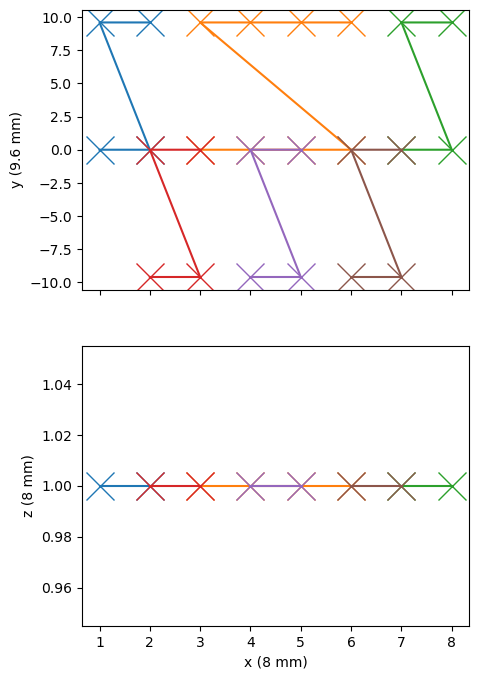

In [64]:
parts = make_parts(setup_wall['bricks'],setup_wall['parts'],1)

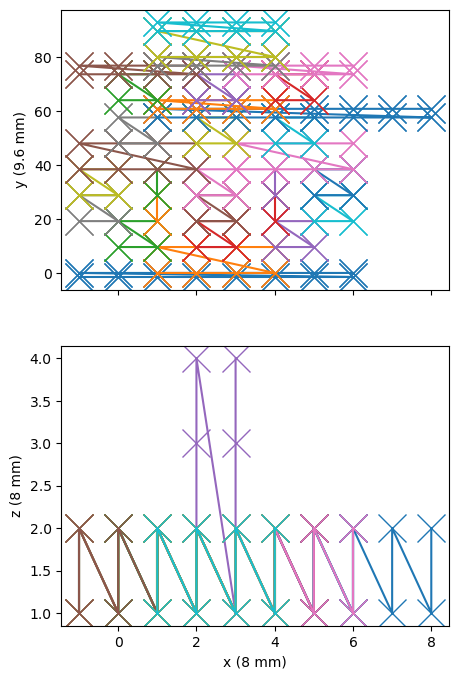

In [65]:
parts = make_parts(assembly_snowman['bricks'],assembly_snowman['parts'],1)

### Check for contact
* oben/unten: 1. Overlap in x-z Ebene?, 2. y_bot - y_top < h_stud
* seitlich: 1. wo ist dx oder dz 0? 2. dort dx oder dz == 1 oder == -1? Wenn ja, dann dementsprechender Seitenwandkontakt

In [66]:
for i_part,part in parts.items():
    print(i_part,part['y_range'],[list(i) for i in list(part['stud_list'])])

1 [-1.5  0. ] [[-1, 1], [-1, 2], [0, 1], [0, 2], [1, 1], [1, 2], [2, 1], [2, 2], [3, 1], [3, 2], [4, 1], [4, 2], [5, 1], [5, 2], [6, 1], [6, 2]]
2 [0.  9.6] [[1, 1], [1, 2], [2, 1], [2, 2], [3, 1], [3, 2], [4, 1], [4, 2]]
3 [ 9.6 19.2] [[0, 1], [0, 2], [1, 1], [1, 2]]
4 [ 9.6 19.2] [[2, 1], [2, 2], [3, 1], [3, 2]]
5 [ 9.6 19.2] [[4, 1], [4, 2], [5, 1], [5, 2]]
6 [19.2 28.8] [[2, 1], [2, 2], [3, 1], [3, 2]]
7 [28.8 38.4] [[2, 1], [2, 2], [3, 1], [3, 2]]
8 [19.2 28.8] [[-1, 1], [-1, 2], [0, 1], [0, 2]]
9 [28.8 38.4] [[-1, 1], [-1, 2], [0, 1], [0, 2]]
10 [19.2 28.8] [[5, 1], [5, 2], [6, 1], [6, 2]]
11 [28.8 38.4] [[5, 1], [5, 2], [6, 1], [6, 2]]
12 [19.2 28.8] [[1, 1], [1, 2]]
13 [28.8 38.4] [[1, 1], [1, 2]]
14 [19.2 28.8] [[4, 1], [4, 2]]
15 [28.8 38.4] [[4, 1], [4, 2]]
16 [38.4 48. ] [[-1, 1], [-1, 2], [0, 1], [0, 2], [1, 1], [1, 2], [2, 1], [2, 2]]
17 [38.4 48. ] [[3, 1], [3, 2], [4, 1], [4, 2], [5, 1], [5, 2], [6, 1], [6, 2]]
18 [48.  57.6] [[0, 1], [0, 2], [1, 1], [1, 2]]
19 [48.  57

In [92]:
def check_two_parts(part1,part2):
    if part1 == part2:
        return ('none', [], [])
    #
    s_list1, s_list2 = part1['stud_list'], part2['stud_list']
    loc = part1['loc']
    y_range1, y_range2 = part1['y_range'], part2['y_range']
    # check for overlap in y-direction
    # --------------------------------------------------------------
    # 'top': s2 ##### TOL dazu...
    if y_range1[1] + h_stud > y_range2[0] and y_range1[1] <= y_range2[0]+TOL:
        # s2 on top of s1
        y_rel = 'top'
    elif y_range2[1] + h_stud > y_range1[0] and y_range2[1] <= y_range1[0]+TOL:
        # s1 on top of s2
        y_rel = 'bot'
    elif ((y_range2[1] > y_range1[0]+TOL and y_range2[1] < y_range1[1]+TOL) or 
          (y_range2[0] < y_range1[1]+TOL and y_range2[0] > y_range1[0]-TOL)):
        # possible side contact of s1 and s2
        y_rel = 'side'
    else:
        y_rel = 'none'
    #
    # check if overlap in x,z plane
    # --------------------------------------------------------------
    # what cavity positions should be widened?
    widen_list = []
    # are the second part studs in contact with part one?
    if_stud_contact = 0

    if y_rel == 'bot':
        for s1 in s_list1:
            for s2 in s_list2:
                # check bottom positions that should be widened in first part
                if list(s1) == list(s2):
                    widen_list += [list(s1-(int(loc[0]/b),int(loc[2]/b)))]
                    if_stud_contact = 1
    
    # check for side contact in x,z plane
    # --------------------------------------------------------------
    side_list = []
    
    if y_rel == 'side':
        for s1 in s_list1:
            for s2 in s_list2:
                # check for side contact, only in positive direction: because checked from both sides
                if (s2-s1)[0] == 1 and (s2-s1)[1] == 0:
                    side_list += [['x1','x0']]
                #elif (s2-s1)[0] == -1:
                #    side_list += [['x0','x1']]
                elif (s2-s1)[1] == 1 and (s2-s1)[0] == 0:
                    side_list += [['z1','z0']]
                #elif (s2-s1)[1] == -1:
                #    side_list += [['z0','z1']]
    #
    # side contact not relevant for overlapping bricks
    return y_rel, widen_list, side_list, if_stud_contact

In [93]:
def make_widen_cont(parts):
    # obtain all stud positions for widening (where studs will stick) and contact pairs
    dict_widen = {}
    cont_list = []

    for k_part in parts.keys():
        dic_temp = {j:check_two_parts(parts[k_part],i) for j,i in parts.items() if j != k_part}
        #print(dic_temp)
        print(dic_temp)
        widen_list = [i[1][0] for i in dic_temp.values() if i[1]!=[]]
        dict_widen[k_part] = widen_list
        # (first part, second part, faces)
        cont_list += [[k_part,i_part,j[2][0]] for i_part,j in dic_temp.items() if j[2] != []]
        # add stud contact
        cont_list += [[k_part,i_part,['bot','top']] for i_part,j in dic_temp.items() if j[-1]==1]

    return dict_widen, cont_list
    

In [94]:
def make_widen_cont(setup):
    # flatten the cavity lists that should be widened
    def flat_cavity(lists_0):
        out_list = []
        for i in lists_0:
            out_list += i
        return out_list
    
    # obtain all stud positions for widening (where studs will stick) and contact pairs
    parts = make_parts(setup['bricks'], setup['parts'], if_plot=0)
    #
    dict_widen = {}
    cont_list = []

    for k_part in parts.keys():
        dic_temp = {j:check_two_parts(parts[k_part],i) for j,i in parts.items() if j != k_part}
        
        widen_list = [i[1] for i in dic_temp.values() if i[1]!=[]]
        dict_widen[k_part] = flat_cavity(widen_list)
        # (first part, second part, faces)
        cont_list += [[k_part,i_part,j[2][0]] for i_part,j in dic_temp.items() if j[2] != []]
        # add stud contact
        cont_list += [[k_part,i_part,['bot','top']] for i_part,j in dic_temp.items() if j[-1]==1]

    return dict_widen, cont_list

In [95]:
make_widen_cont(setup_wall)

({1: [[2, 1]],
  2: [[1, 1], [2, 1], [3, 1], [4, 1]],
  4: [[1, 1]],
  5: [],
  6: [],
  7: []},
 [[1, 2, ['x1', 'x0']],
  [1, 5, ['bot', 'top']],
  [2, 4, ['x1', 'x0']],
  [2, 5, ['bot', 'top']],
  [2, 6, ['bot', 'top']],
  [2, 7, ['bot', 'top']],
  [4, 7, ['bot', 'top']],
  [5, 6, ['x1', 'x0']],
  [6, 7, ['x1', 'x0']]])

In [97]:
cav_widen,cont_list = make_widen_cont(assembly_snowman)
cont_list

[[2, 1, ['bot', 'top']],
 [3, 4, ['x1', 'x0']],
 [3, 2, ['bot', 'top']],
 [4, 5, ['x1', 'x0']],
 [4, 2, ['bot', 'top']],
 [5, 2, ['bot', 'top']],
 [6, 14, ['x1', 'x0']],
 [6, 4, ['bot', 'top']],
 [7, 15, ['x1', 'x0']],
 [7, 6, ['bot', 'top']],
 [8, 12, ['x1', 'x0']],
 [8, 3, ['bot', 'top']],
 [9, 13, ['x1', 'x0']],
 [9, 8, ['bot', 'top']],
 [10, 5, ['bot', 'top']],
 [11, 10, ['bot', 'top']],
 [12, 6, ['x1', 'x0']],
 [12, 3, ['bot', 'top']],
 [13, 7, ['x1', 'x0']],
 [13, 12, ['bot', 'top']],
 [14, 10, ['x1', 'x0']],
 [14, 5, ['bot', 'top']],
 [15, 11, ['x1', 'x0']],
 [15, 14, ['bot', 'top']],
 [16, 17, ['x1', 'x0']],
 [16, 7, ['bot', 'top']],
 [16, 9, ['bot', 'top']],
 [16, 13, ['bot', 'top']],
 [17, 7, ['bot', 'top']],
 [17, 11, ['bot', 'top']],
 [17, 15, ['bot', 'top']],
 [18, 19, ['x1', 'x0']],
 [18, 16, ['bot', 'top']],
 [19, 20, ['x1', 'x0']],
 [19, 16, ['bot', 'top']],
 [19, 17, ['bot', 'top']],
 [20, 17, ['bot', 'top']],
 [21, 18, ['bot', 'top']],
 [21, 19, ['bot', 'top']],
 [21,

In [98]:
cav_widen

{1: [],
 2: [[1, 1], [1, 2], [2, 1], [2, 2], [3, 1], [3, 2], [4, 1], [4, 2]],
 3: [[2, 1], [2, 2]],
 4: [[1, 1], [1, 2], [2, 1], [2, 2]],
 5: [[1, 1], [1, 2]],
 6: [[1, 1], [1, 2], [2, 1], [2, 2]],
 7: [[1, 1], [1, 2], [2, 1], [2, 2]],
 8: [[2, 1], [2, 2]],
 9: [[1, 1], [1, 2], [2, 1], [2, 2]],
 10: [[1, 1], [1, 2]],
 11: [[1, 1], [1, 2], [2, 1], [2, 2]],
 12: [[1, 1], [1, 2]],
 13: [[1, 1], [1, 2]],
 14: [[1, 1], [1, 2]],
 15: [[1, 1], [1, 2]],
 16: [[4, 1], [4, 2], [1, 1], [1, 2], [2, 1], [2, 2], [3, 1], [3, 2]],
 17: [[1, 1], [1, 2], [3, 1], [3, 2], [4, 1], [4, 2], [2, 1], [2, 2]],
 18: [[1, 1], [1, 2], [2, 1], [2, 2]],
 19: [[1, 1], [1, 2], [2, 1], [2, 2]],
 20: [[1, 1], [1, 2], [2, 1], [2, 2]],
 21: [[1, 1],
  [1, 2],
  [2, 1],
  [2, 2],
  [3, 1],
  [3, 2],
  [4, 1],
  [4, 2],
  [5, 1],
  [5, 2]],
 22: [[1, 1], [1, 2], [2, 1], [2, 2], [3, 1], [3, 2], [4, 1], [4, 2]],
 23: [[2, 1], [2, 2]],
 24: [[1, 1], [1, 2]],
 25: [[1, 1], [1, 2], [2, 1], [2, 2]],
 26: [[2, 1], [2, 2], [3, 1], 